In [1]:
import numpy as np
import pandas as pd
import os
import pathlib

# data viz
from matplotlib import pyplot as plt
import seaborn as sns           # for nicer plots
sns.set(style="darkgrid")       # default style

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# tf
import tensorflow as tf


# Step 1: Data Ingestion

Available at `02-choose-trgt-and-preprocess-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 2: Data Preprocessing

Available at `02-choose-trgt-and-preprocess-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 3: Exploratory Data Analysis

Available at `03-eda-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 4: Consider Feature Selection

Exploration of feature selection using pearson correlation and feature importance are available in `04-feature-select-imputemeansubgr-smontenc-sa.ipynb` notebook. Since we have over 51,500 samples to feature ratio, we will use all features from Step 2 in model building.

# Step 5: Modeling (Base Model - Random Forrest)

`load preprocessed data`

In [2]:
DATA_PATH = '../data/processed/'
FILE_NAME = 'fpafod_scaled.npz'

fpafod = np.load(DATA_PATH+FILE_NAME)

In [3]:
fpafod.files

['X_train_res_std',
 'Y_train_resampled',
 'X_val_std',
 'Y_val',
 'X_test_std',
 'Y_test']

In [4]:
X_train_res_std = fpafod['X_train_res_std']
Y_train_resampled = fpafod['Y_train_resampled']
X_val_std = fpafod['X_val_std']
Y_val = fpafod['Y_val']
X_test_std = fpafod['X_test_std']
Y_test = fpafod['Y_test']

print(f"\nShape of X_train_resampled: {X_train_res_std.shape}")
print(f"Shape of X_val: {X_val_std.shape}")
print(f"Shape of X_test: {X_test_std.shape}")

print(f"\nShape of Y_train_resampled: {Y_train_resampled.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_test: {Y_test.shape}")


Shape of X_train_resampled: (5380328, 104)
Shape of X_val: (460504, 104)
Shape of X_test: (460505, 104)

Shape of Y_train_resampled: (5380328,)
Shape of Y_val: (460504,)
Shape of Y_test: (460505,)


#### Train Model

`Initial model`

In [5]:
# use the RandomForestClassifier from sklearn to train X_train_res_std and Y_train_resampled
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                n_jobs=1, # default
                                random_state=207,
                                max_features= 'sqrt', # default
                                max_depth=8 
                                )

clf_forest = forest.fit(X_train_res_std, Y_train_resampled)

In [6]:
def print_report(fitted_clf, X, Y, txt = 'Data'):
    target_labels = ['level_1', 'level_2', 'level_3', 'level_4']
    Y_pred = fitted_clf.predict(X)
    print(f"\n*** {txt} ***")
    print(classification_report(Y, Y_pred, target_names=target_labels, digits=5))


In [7]:
print_report(clf_forest, X=X_train_res_std, Y=Y_train_resampled, txt="Training Data")
print_report(clf_forest, X=X_val_std, Y=Y_val, txt="Validation Data")


*** Training Data ***
              precision    recall  f1-score   support

     level_1    0.73284   0.77254   0.75217   1345082
     level_2    0.65630   0.44356   0.52935   1345082
     level_3    0.52792   0.49618   0.51156   1345082
     level_4    0.61345   0.81596   0.70036   1345082

    accuracy                        0.63206   5380328
   macro avg    0.63263   0.63206   0.62336   5380328
weighted avg    0.63263   0.63206   0.62336   5380328


*** Validation Data ***
              precision    recall  f1-score   support

     level_1    0.98712   0.77199   0.86640    448361
     level_2    0.06512   0.30469   0.10731     11185
     level_3    0.00764   0.38753   0.01499       738
     level_4    0.00547   0.50000   0.01083       220

    accuracy                        0.75990    460504
   macro avg    0.26634   0.49106   0.24988    460504
weighted avg    0.96269   0.75990   0.84619    460504



In [8]:
def plot_confusion_matrix_rf(fitted_clf):
    Y_val_pred = fitted_clf.predict(X_val_std)
    target_labels = ['level_1', 'level_2', 'level_3', 'level_4']
    cf = tf.math.confusion_matrix(Y_val, Y_val_pred)
    ax = sns.heatmap(cf, annot=True, fmt='d', cmap='Blues',
                    cbar=False,
                    annot_kws={'fontsize': 10},
                    xticklabels=target_labels,
                    yticklabels=target_labels)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    ax.set_title('Baseline Model Confusion matrix: Validation data')
    plt.show() 

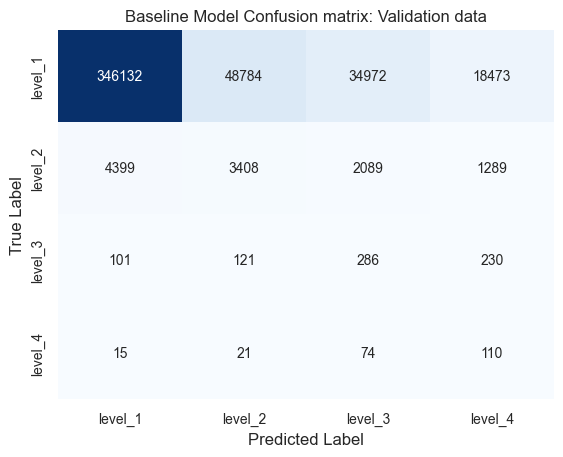

In [9]:
plot_confusion_matrix_rf(clf_forest)

`tune model`

In [10]:
def train_and_evaluate_rf(criterion='entropy',
                          n_estimators=10, 
                          max_features= 'sqrt',
                          max_depth=8
):
    rf = RandomForestClassifier(criterion=criterion,
                                n_estimators=n_estimators, 
                                n_jobs=1, # default
                                random_state=207,
                                max_features= max_features,
                                max_depth=max_depth
                                )
    clf_rf = rf.fit(X_train_res_std, Y_train_resampled)

    # print report
    print_report(clf_rf, X=X_train_res_std, Y=Y_train_resampled, txt="Training Data")
    print_report(clf_rf, X=X_val_std, Y=Y_val, txt="Validation Data")

    # plot confusion matrix
    plot_confusion_matrix_rf(clf_rf)
    


*** Training Data ***
              precision    recall  f1-score   support

     level_1    0.99768   0.99052   0.99409   1345082
     level_2    0.99196   0.99369   0.99283   1345082
     level_3    0.99609   0.99912   0.99760   1345082
     level_4    0.99759   0.99997   0.99878   1345082

    accuracy                        0.99583   5380328
   macro avg    0.99583   0.99583   0.99582   5380328
weighted avg    0.99583   0.99583   0.99582   5380328


*** Validation Data ***
              precision    recall  f1-score   support

     level_1    0.98187   0.95443   0.96795    448361
     level_2    0.15306   0.31024   0.20499     11185
     level_3    0.05197   0.10569   0.06967       738
     level_4    0.04790   0.10909   0.06657       220

    accuracy                        0.93702    460504
   macro avg    0.30870   0.36986   0.32730    460504
weighted avg    0.95980   0.93702   0.94755    460504



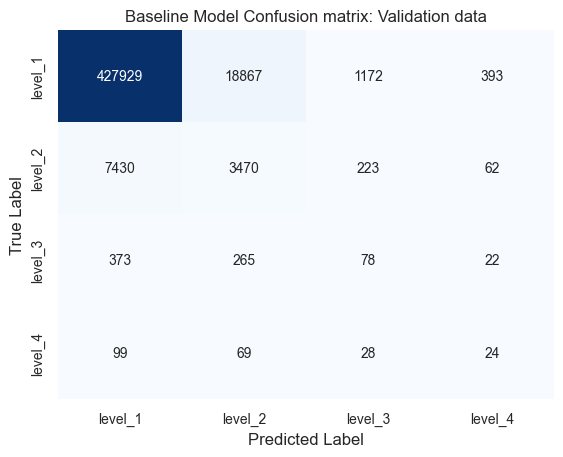

In [11]:
# conduct experiments and record results in an ablation table
train_and_evaluate_rf(
    n_estimators=75,
    max_depth=25
)